In [1]:

import matplotlib.pyplot as plt
%matplotlib inline

import sys
import os

import scipy.sparse.linalg as spsl

import numpy as np




In [2]:


h1=5
w1=1

newpath = os.path.join(os.getcwd(),'SteinFigures/h'+repr(h1))
if not os.path.exists(newpath):
        os.makedirs(newpath)

def force(x):
    return -h1*4*(x**2-w1)*x;
def energy(x):
    return h1*(x**2-w1)**2

nrSteps = 1000

x = np.ones(nrSteps)
p = np.random.randn(nrSteps)
dt=0.01
gamma = 1
kT = 1
a = np.exp(-gamma * (dt))
b = np.sqrt(1 - np.exp(-2 * gamma * (dt)))


pn = p[0]
xn = x[0]
    
f=force(xn)

for n in range(nrSteps-1):
        
        if n % 10 ==0:
            pn = p[0]
            xn = x[0]
        
        pn = pn + 0.5* f * dt
        xn = xn + 0.5* pn * dt
        pn = (a * pn) + b * np.random.randn(*xn.shape) * np.sqrt(kT)
        f=force(xn)
        xn = xn + 0.5* pn * dt
        pn = pn + 0.5* f * dt
        
        p[n+1] = pn
        x[n+1] = xn
    


In [3]:
# take a gaussian as initial conditions.
x = np.random.randn(nrSteps) * 0.1 + 0.8

q_density = 1.0/np.sqrt(2*np.pi*0.1**2) * np.exp(-(x-.2)**2 / (2*0.1**2))

X0=x

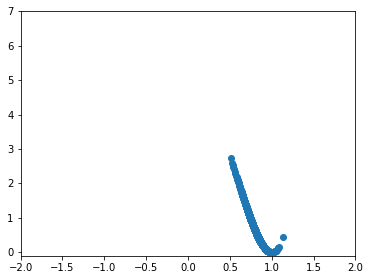

In [4]:
def plotSampling_fromData(x, methodName=None, color='b', title = 'Initial condition', savefigure=None):
    
    fig = plt.figure(figsize=(6,4.5))
    ax = fig.add_subplot(111)
    ax.scatter(x, energy(x))
    ax.set_xlim([-2,2])
    ax.set_ylim([-0.1,7])
    if savefigure is not None:
        plt.savefig(savefigure,  format='png', dpi=100, bbox_inches='tight')
        
    plt.show()
        
   
    
plotSampling_fromData(x, methodName=None, color='b', title = 'Initial condition', savefigure=None)

#  Stein force

In [5]:
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import cdist

def compute_force(XL, leader_set):
       
    f = []
    
    for n in range(len(leader_set)):
        f.append( force(XL[leader_set[n]]))

    return f

def compute_force_all(XL):
       
    f = []
    
    for n in range(len(XL)):
        f.append( force(XL[n]))

    return f

def compute_stein_force(XL, leader_set):
   
    my_force = compute_force(XL, leader_set)
    # create numpy array from the list force which has also units    
    force_resh = np.asarray(my_force)
    # create numpy array from the list XL which has also units
    
    # choose leader particles using the index set leader_set
    X_leader = XL[leader_set]
   
    # kernel scaling parameter
    h=0.1
    
    distances = cdist(XL[:,np.newaxis], X_leader[:,np.newaxis])
    kernel = np.exp(-distances**2 / h)
    
    # this computes the first part (without the kernel derivatives)
    # f_MDforce is of the format (N_particles, dim)
    f_MDforce = np.dot(kernel, force_resh)
    f_MDforce = f_MDforce / len(leader_set)
    # add force unit and divide by kT
    #f_MDforce = f_MDforce * model.force_unit / smpl.kT
    f_MDforce = f_MDforce  / kT
    
    #derivative part
    f_der = -2.0/h * np.dot(kernel, X_leader)
    f_der += 2.0/h * np.sum(kernel,1) * XL
    f_der = f_der / len(leader_set)
    # add unit
    #f_der = f_der * model.x_unit**(-1)
    
    grad_force = (-2.0/h*XL*np.dot(kernel, force_resh) +2.0/h * np.dot(kernel, X_leader*force_resh)) / kT
    grad_force += 2.0/h*np.sum(kernel,1)
    grad_force -= 4.0/(h**2) * (XL**2 * np.sum(kernel,1) -2.0*XL * np.dot(kernel, X_leader) + np.dot(kernel, X_leader**2))
    grad_force = grad_force / len(leader_set)
    
    return f_MDforce + f_der, grad_force

#def update_weights(XL, leader_set, q_dens):
    





# Iterate Stein

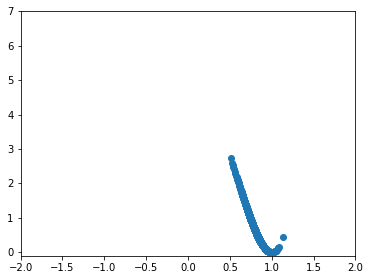

Stein iteration 0


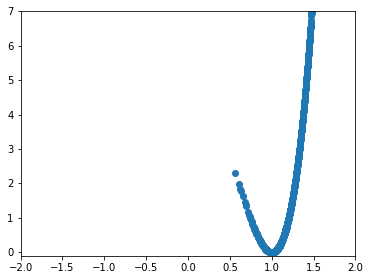

Stein iteration 5


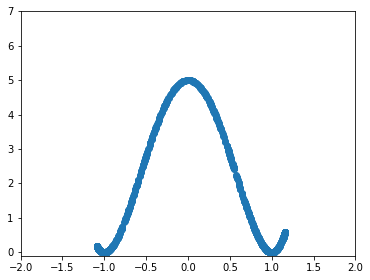

Stein iteration 10


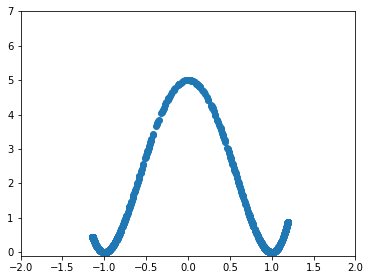

Stein iteration 15


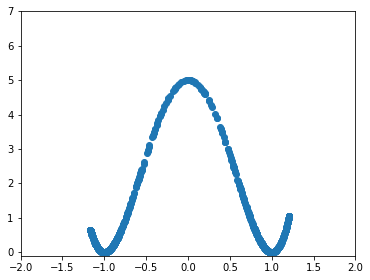

Stein iteration 20


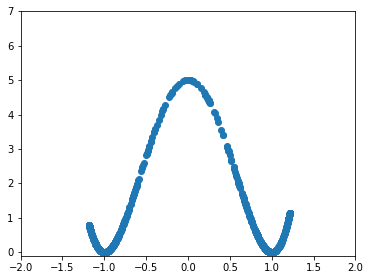

Stein iteration 25


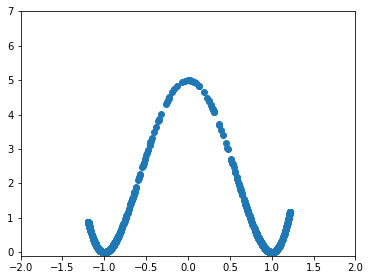

Stein iteration 30


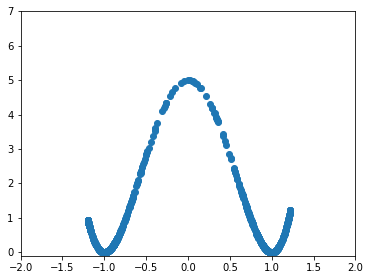

Stein iteration 35


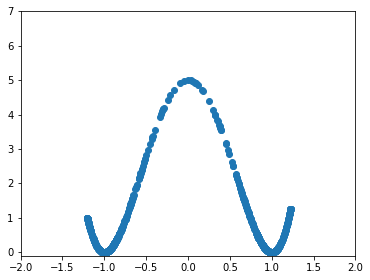

Stein iteration 40


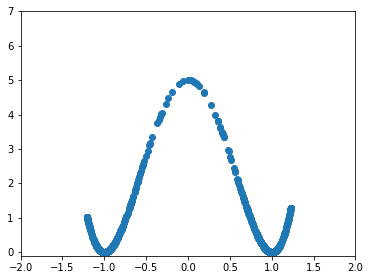

Stein iteration 45


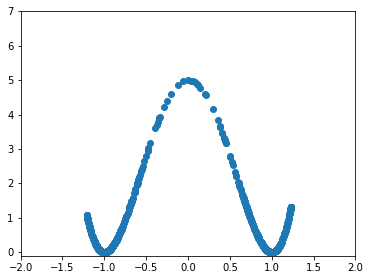

Stein iteration 50


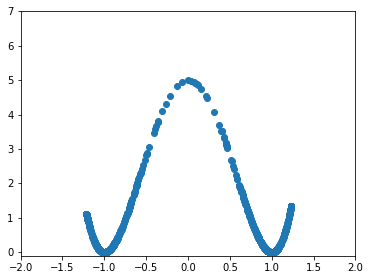

Stein iteration 55


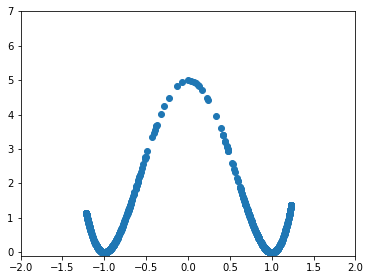

Stein iteration 60


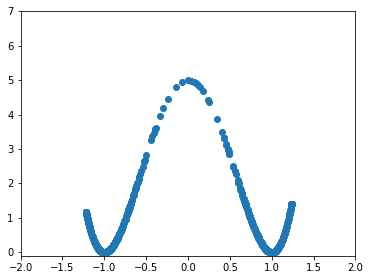

Stein iteration 65


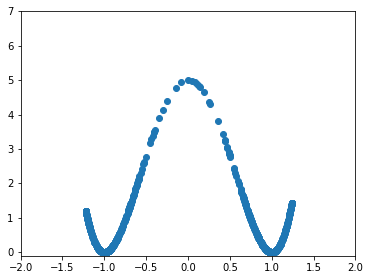

Stein iteration 70


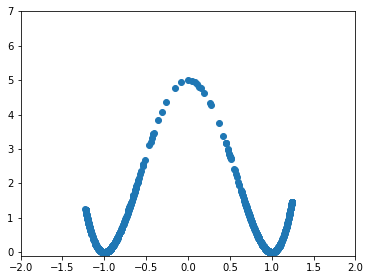

Stein iteration 75


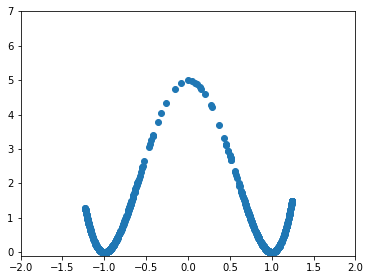

Stein iteration 80


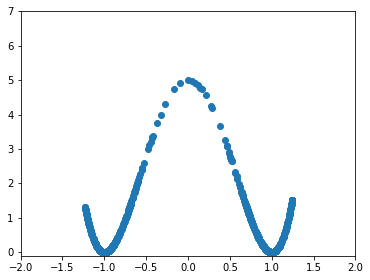

Stein iteration 85


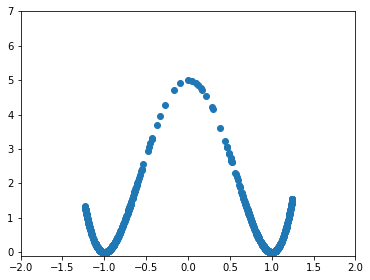

Stein iteration 90


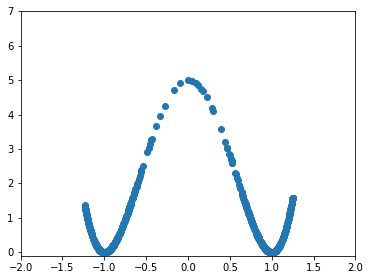

Stein iteration 95


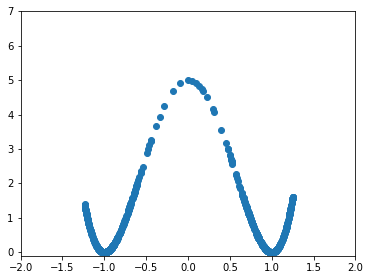

In [11]:
numberOfSteinSteps = 100#50000

X_short = np.copy(X0)

epsilon_step=0.1

# choose leader set
numberOfLeaderParticles = int(0.9*(X_short.shape[0]))
leader_set =np.array(range(X_short.shape[0]))# np.random.choice(range(X_short.shape[0]), numberOfLeaderParticles)#np.array(range(X_short.shape[0]))# 

mass = 1 

q = X_short

XL=np.copy(q)
plotSampling_fromData(q, methodName=None, color='b', title = 'Initial condition')
f = compute_stein_force(XL,leader_set)
#f = compute_force(XL)

modit = int(numberOfSteinSteps/20)
moditfig = int(numberOfSteinSteps/20)
KL = np.zeros(numberOfSteinSteps)
Obs_average = np.zeros(numberOfSteinSteps)

states_evolution_stein =[]

for ns in range(numberOfSteinSteps):
    if ns%modit==0:
        print('Stein iteration '+repr(ns))
    f, grad_force = compute_stein_force(XL,leader_set)
    XL = (XL + epsilon_step * f)#/mass );
    q =  np.copy(XL)
    q_density = q_density / abs(1.0 + epsilon_step*grad_force)
    
    weights = np.exp(-energy(q)) / q_density
    KL[ns] = np.mean(np.log(weights))
    #Obs_average[ns] = np.sum(weights*q) / np.sum(weights)
    Obs_average[ns] = np.mean(q)
    states_evolution_stein.append(q)
    
    ## plot progress
    if ns%moditfig==0:
        plotSampling_fromData(q, methodName=None, color='b', title = 'Initial condition', savefigure=None)
    if np.isnan(q).any():
        print('Explosion. Nan.')
        break
    

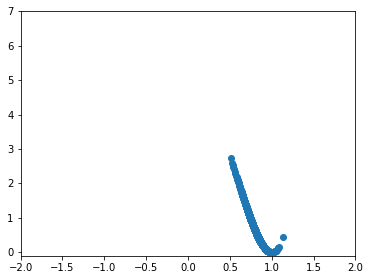

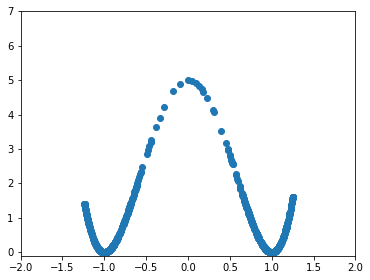

In [12]:
plotSampling_fromData(X0,  methodName=None, color='b', title='Initial state')
plotSampling_fromData(q, methodName=None, color='b', title = 'After '+repr(numberOfSteinSteps)+' Stein steps')


In [13]:
# from scipy.integrate import quadrature
# def fit_distribution(x):
#     x = x[:,0,0]
#     Z = 0.5725340617#quadrature(lambda y : np.exp(-energy(y)), -1000, 1000)[1]
#     xx = np.linspace(-2,2,100)
    
#     fig = plt.figure(figsize=(6,4.5))
#     ax = fig.add_subplot(111)
#     ax.hist(x, 50, density=True);
#     ax.scatter(xx, np.exp(- energy(xx))/Z , c='r', s=5)
   
#     plt.show()

In [14]:
# fit_distribution(q)


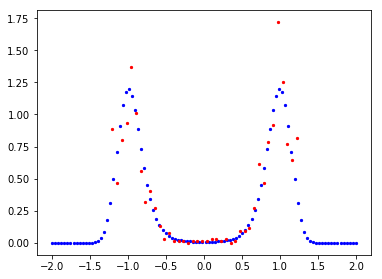

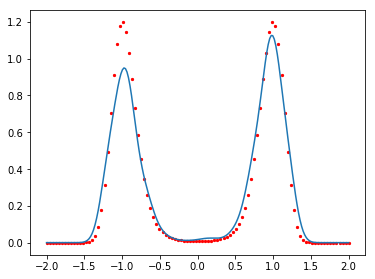

In [15]:
fig = plt.figure(figsize=(6,4.5))
ax = fig.add_subplot(111)
x = q
data, bins = np.histogram(x, 40, density=True)
bin_centers = 0.5*(bins[1:] + bins[:-1])
xx = np.linspace(-2,2,100)
Z = sum(np.exp(-energy(xx))) * (xx[1]-xx[0])
ax.scatter(xx, np.exp(- energy(xx))/Z , c='b', s=5)
ax.scatter(bin_centers, data , c='r', s=5)
plt.show()

from sklearn.neighbors.kde import KernelDensity
kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(q.reshape(-1,1))

X_plot = np.linspace(-2, 2, 200)[:, np.newaxis]
log_dens = kde.score_samples(X_plot)

fig = plt.figure(figsize=(6,4.5))
plt.plot(X_plot[:, 0], np.exp(log_dens), '-')
plt.scatter(xx, np.exp(- energy(xx))/Z , c='r', s=5)
plt.show()

In [16]:
Z = 1.973732150#0.5725340617
print('Z='+repr(Z))

print('E[x] = 0')
print(np.mean(X_short))
print(np.mean(q))
print('************')

print('E[V(x)] = .4172545129')#0.5247724179')
print(np.mean(energy(X_short)))
print(np.mean(energy(q)))
print('************')

print('E[-f(x)*x] = 1')
print(np.mean((-force(X_short)* X_short)))
print((np.mean(-force(q)* q)))

Z=1.97373215
E[x] = 0
0.799932551358
0.0786993695933
************
E[V(x)] = .4172545129
0.740166334476
0.569068059167
************
E[-f(x)*x] = 1
-4.04952567751
0.920963078681


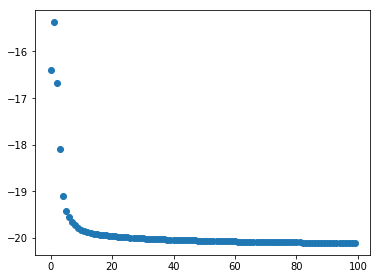

In [17]:
fig = plt.figure(figsize=(6,4.5))
ax = fig.add_subplot(1, 1, 1)
#ax.set_yscale('log')
ax.scatter(np.arange(numberOfSteinSteps), -KL)
#ax.set_ylim(1e-4, 1)
plt.show()

In [18]:
# import glob
# import moviepy.editor as mpy

# gif_name = 'SteinFigures/stein'
# fps = 1000
# file_list = glob.glob('SteinFigures/'+'/*.png') # Get all the pngs in the current directory
# list.sort(file_list, key=lambda x: int(x.split('_')[1].split('.png')[0])) # Sort the images by #, this may need to be tweaked for your use case
# clip = mpy.ImageSequenceClip(file_list, fps=fps)
# clip.write_gif('{}.gif'.format(gif_name), fps=fps)

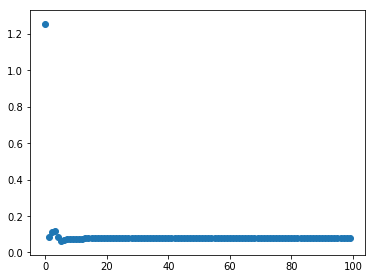

In [19]:
fig = plt.figure(figsize=(6,4.5))
ax = fig.add_subplot(1, 1, 1)
#ax.set_yscale('log')
ax.scatter(np.arange(numberOfSteinSteps), Obs_average)
#ax.set_ylim(1e-4, 1)
plt.show()

# Parallel Langevin steps

In [20]:
#x = np.ones(nrSteps)
#p = np.random.randn(nrSteps)

def Langevin_step(x, p, dt):
    
    gamma = 1
    kT = 1
    a = np.exp(-gamma * (dt))
    b = np.sqrt(1 - np.exp(-2 * gamma * (dt)))
    
    for n in range(len(x)):
        
        xn=x[n]
        pn=p[n]
        
        f = force(xn)
      
        pn = pn + 0.5* f * dt
        xn = xn + 0.5* pn * dt
        pn = (a * pn) + b * np.random.randn(*xn.shape) * np.sqrt(kT)
        f = force(xn)
        xn = xn + 0.5* pn * dt
        pn = pn + 0.5* f * dt
        
        x[n]=xn
        p[n]=pn
        
    return x, p


In [21]:
#numberOfSteinSteps = 1000

(1,)


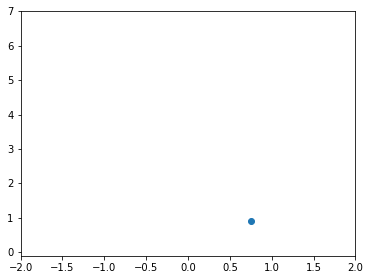

Langevin iteration 0


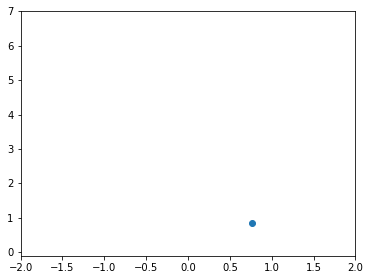

In [22]:
numberOfSteinSteps =10000# 1000#50000
modit=100000
moditfig=100000

gamma = 1
kT = 1
a = np.exp(-gamma * (dt))
b = np.sqrt(1 - np.exp(-2 * gamma * (dt)))

X_short = np.copy(X0[0:1])
p = np.random.randn(*x.shape)

dt_step=0.01
mass = 1 

q = X_short
print(q.shape)

XL=np.copy(q)
plotSampling_fromData(q, methodName=None, color='b', title = 'Initial condition')
#f = compute_force_all(XL)

# modit = int(numberOfSteinSteps/20)
# moditfig = int(numberOfSteinSteps/20)
# KL = np.zeros(numberOfSteinSteps)
Obs_average = np.zeros(numberOfSteinSteps)
#f = compute_force_all(XL)


#states_evolution_Langevin=[]
states_evolution_Langevin_serial=[]

for ns in range(numberOfSteinSteps):
    if ns%modit==0:
        print('Langevin iteration '+repr(ns))
    #f = compute_force_all(XL)
    q, p = Langevin_step(q, p, dt_step) #(XL + epsilon_step * f)#/mass );
#    print(q.shape)
#    states_evolution_Langevin.append(np.copy(q))
    states_evolution_Langevin_serial.append(np.copy(q))
    #while(1):
    #    pass
    #q =  np.copy(XL)
    #q_density = q_density / abs(1.0 + epsilon_step*grad_force)
    
    #weights = np.exp(-energy(q)) / q_density
    #KL[ns] = np.mean(np.log(weights))
    #Obs_average[ns] = np.sum(weights*q) / np.sum(weights)
    #print(q.shape)
    Obs_average[ns] = np.mean(q)
    
    ## plot progress
    if ns%moditfig==0:
        plotSampling_fromData(q, methodName=None, color='b', title = 'Initial condition', savefigure=None)
    if np.isnan(q).any():
        print('Explosion. Nan.')
        break
    

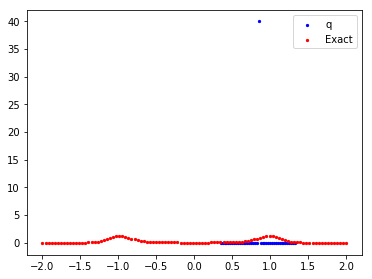

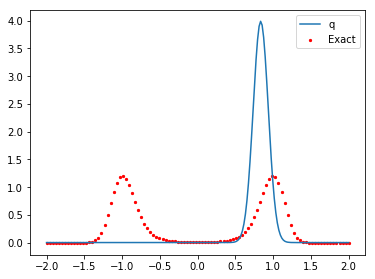

In [23]:
fig = plt.figure(figsize=(6,4.5))
ax = fig.add_subplot(111)
x = q
data, bins = np.histogram(x, 40, density=True)
bin_centers = 0.5*(bins[1:] + bins[:-1])
xx = np.linspace(-2,2,100)
Z = sum(np.exp(-energy(xx))) * (xx[1]-xx[0])
ax.scatter(bin_centers, data , c='b', s=5)
ax.scatter(xx, np.exp(- energy(xx))/Z , c='r', s=5)
plt.legend(['q','Exact' ])
plt.show()

from sklearn.neighbors.kde import KernelDensity
kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(q.reshape(-1,1))

X_plot = np.linspace(-2, 2, 200)[:, np.newaxis]
log_dens = kde.score_samples(X_plot)

fig = plt.figure(figsize=(6,4.5))
plt.plot(X_plot[:, 0], np.exp(log_dens), '-')
plt.scatter(xx, np.exp(- energy(xx))/Z , c='r', s=5)
plt.legend(['q','Exact' ])
plt.show()

In [24]:
Z = 1.973732150#0.5725340617
print('Z='+repr(Z))

print('E[x] = 0')
print(np.mean(X0))
print(np.mean(q))
print('************')

print('E[V(x)] = .4172545129')#0.5247724179')
print(np.mean(energy(X0)))
print(np.mean(energy(q)))
print('************')

print('E[-f(x)*x] = 1')
print(np.mean((-force(X0)* X0)))
print((np.mean(-force(q)* q)))

Z=1.97373215
E[x] = 0
0.799932551358
0.835539754101
************
E[V(x)] = .4172545129
0.740166334476
0.455637504576
************
E[-f(x)*x] = 1
-4.04952567751
-4.21491636803


In [25]:
# import pandas as pd
# df_Langevin = pd.DataFrame(data=q)

# from pandas.plotting import autocorrelation_plot


# Lag=np.arange(0, 10)
# print(Lag)
# plt.figure()

# data = pd.Series(q)

# acf = np.zeros(len(Lag))
# for i in range(len(Lag)):
#     acf[i] = data.autocorr(lag=Lag[i])
# print(acf)
# plt.plot(Lag, acf)
# plt.show()

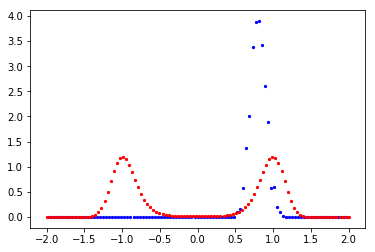

In [26]:
xx = np.linspace(-2,2,100)
data, bins = np.histogram(X0, xx, density=True)

bin_centers = 0.5*(bins[1:] + bins[:-1])

Z = sum(np.exp(-energy(xx))) * (xx[1]-xx[0])
plt.scatter(bin_centers, data , c='b', s=5)
plt.scatter(xx, np.exp(- energy(xx))/Z , c='r', s=5)
plt.savefig('SteinFigures/h'+repr(h1)+'/initial_distribution.png',  format='png', dpi=100, bbox_inches='tight')
plt.show()




In [27]:
states_evolution_stein.shape

AttributeError: 'list' object has no attribute 'shape'

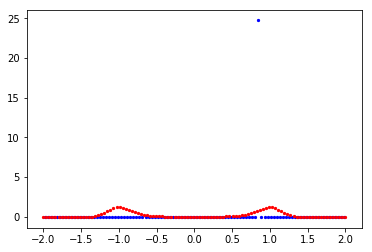

5.4122479853


NameError: name 'states_evolution_Langevin' is not defined

In [28]:


xx = np.linspace(-2,2,100)
data, bins = np.histogram(x, xx, density=True)

bin_centers = 0.5*(bins[1:] + bins[:-1])

Z = sum(np.exp(-energy(xx))) * (xx[1]-xx[0])
plt.scatter(bin_centers, data , c='b', s=5)
plt.scatter(xx, np.exp(- energy(xx))/Z , c='r', s=5)
plt.show()

init=0

hist_exact=np.exp(- energy(xx))/Z 
print(np.linalg.norm(hist_exact[:-1] - data)/np.linalg.norm(hist_exact[:-1] ))
err_stein=np.zeros(numberOfSteinSteps)
err_langevin=np.zeros(numberOfSteinSteps)

for n in range(numberOfSteinSteps):
    
    q_curr_stein = states_evolution_stein[n]

    q_curr_langevin = states_evolution_Langevin[n]
   
    #q_curr_langevin = q_curr_langevin.reshape(q_curr_langevin.shape[0]*q_curr_langevin.shape[1])
    #print(q_curr_langevin.shape)
    
    data_stein, bins = np.histogram(q_curr_stein, xx, density=True)
    data_langevin, bins = np.histogram(q_curr_langevin, xx, density=True)
    
    err_stein[n] = np.linalg.norm(hist_exact[:-1] - data_stein)/np.linalg.norm(hist_exact[:-1] )
    err_langevin[n] = np.linalg.norm(hist_exact[:-1] - data_langevin)/np.linalg.norm(hist_exact[:-1] )


In [63]:
q_curr_stein = states_evolution_stein[-1]

q_curr_langevin = np.asarray(states_evolution_Langevin)
q_curr_langevin=q_curr_langevin.reshape(q_curr_langevin.shape[0]*q_curr_langevin.shape[1])
print(q_curr_langevin.shape)
   
    #q_curr_langevin = q_curr_langevin.reshape(q_curr_langevin.shape[0]*q_curr_langevin.shape[1])
    #print(q_curr_langevin.shape)
    
data_stein, bins = np.histogram(q_curr_stein, xx, density=True)
data_langevin, bins = np.histogram(q_curr_langevin, xx, density=True)
bin_centers = 0.5*(bins[1:] + bins[:-1])
err_st = np.linalg.norm(hist_exact[:-1] - data_stein)/np.linalg.norm(hist_exact[:-1] )
err_lang = np.linalg.norm(hist_exact[:-1] - data_langevin)/np.linalg.norm(hist_exact[:-1] )
print('stein err '+repr(err_st))
print('lang err '+repr(err_lang))

(10000000,)
stein err 0.22199119386803434
lang err 0.92652419809681075


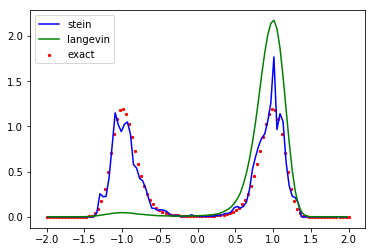

In [66]:
plt.plot(bin_centers, data_stein , 'b')#, s=5)
plt.plot(bin_centers, data_langevin , 'g')#, s=5)
plt.scatter(xx, np.exp(- energy(xx))/Z , c='r', s=5)
plt.legend(['stein','langevin','exact'])
plt.show()

In [ ]:
fig = plt.figure(figsize=(6,4.5))
ax = fig.add_subplot(111)

ax.loglog(range(init,numberOfSteinSteps), err_stein[init:])
ax.loglog(range(init,numberOfSteinSteps), err_langevin[init:])
ax.legend(['Stein','Langevin'])
ax.set_xlabel('steps')
ax.set_ylabel('Relative error')
plt.savefig('SteinFigures/h'+repr(h1)+'/error.png',  format='png', dpi=100, bbox_inches='tight')
plt.show()

2.31095884747


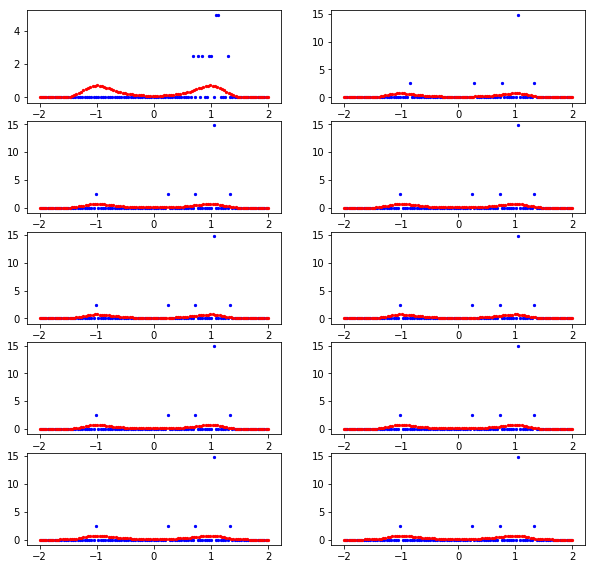

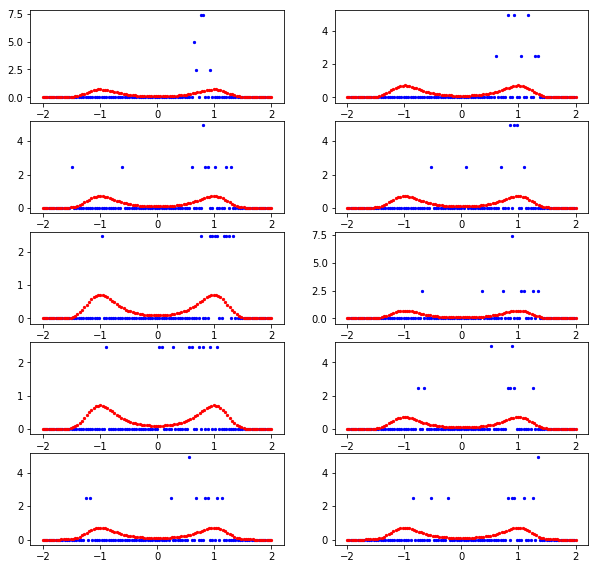

In [23]:
modnr=100
xx = np.linspace(-2,2,100)
data, bins = np.histogram(x, xx, density=True)

bin_centers = 0.5*(bins[1:] + bins[:-1])

Z = sum(np.exp(-energy(xx))) * (xx[1]-xx[0])
# plt.scatter(bin_centers, data , c='b', s=5)
# plt.scatter(xx, np.exp(- energy(xx))/Z , c='r', s=5)
# plt.show()


hist_exact=np.exp(- energy(xx))/Z 
print(np.linalg.norm(hist_exact[:-1] - data)/np.linalg.norm(hist_exact[:-1] ))
err_stein=np.zeros(numberOfSteinSteps)
err_langevin=np.zeros(numberOfSteinSteps)

fig = plt.figure(figsize=(10,20))
nrrows=10
i=0

for n in range(numberOfSteinSteps):
    q_curr_stein = states_evolution_stein[n]
    
    data_stein, bins = np.histogram(q_curr_stein, xx, density=True)
 
    bin_centers = 0.5*(bins[1:] + bins[:-1])
    if n%modnr==0:
        
        
        ax = fig.add_subplot(nrrows, 2 ,i+1)
        i+=1
        
        ax.scatter(bin_centers, data_stein , c='b', s=5)
        ax.scatter(xx, np.exp(- energy(xx))/Z , c='r', s=5)
plt.savefig('SteinFigures/h'+repr(h1)+'/Stein.png',  format='png', dpi=100, bbox_inches='tight')
plt.show()

fig = plt.figure(figsize=(10,20))
nrrows=10
i=0

for n in range(numberOfSteinSteps):

    q_curr_langevin = states_evolution_Langevin[n]
    
    
    data_langevin, bins = np.histogram(q_curr_langevin, xx, density=True)
    bin_centers = 0.5*(bins[1:] + bins[:-1])
    if n%modnr==0:
        
        
        ax = fig.add_subplot(nrrows, 2 ,i+1)
        i+=1
        
        ax.scatter(bin_centers, data_langevin , c='b', s=5)
        ax.scatter(xx, np.exp(- energy(xx))/Z , c='r', s=5)
plt.savefig('SteinFigures/h'+repr(h1)+'/Langevin.png',  format='png', dpi=100, bbox_inches='tight')
plt.show()
    


In [24]:
# import glob
# import moviepy.editor as mpy

# gif_name = 'SteinFigures/h'+repr(h1)+'/gif/Langevin/langevin'
# fps = 1
# file_list = glob.glob('SteinFigures/h'+repr(h1)+'/gif/Langevin/*.png') # Get all the pngs in the current directory
# #list.sort(file_list, key=lambda x: int(x.split('_')[1].split('.png')[0])) # Sort the images by #, this may need to be tweaked for your use case
# clip = mpy.ImageSequenceClip(file_list, fps=fps)
# clip.write_gif('{}.gif'.format(gif_name), fps=fps)

In [13]:
#np.save('SteinFigures/h'+repr(h1)+'/langevin_data.npy',states_evolution_Langevin)
#np.save('SteinFigures/h'+repr(h1)+'/stein_data.npy',states_evolution_stein)

states_evolution_Langevin = np.load('SteinFigures/h'+repr(h1)+'/langevin_data.npy')
states_evolution_stein = np.load('SteinFigures/h'+repr(h1)+'/stein_data.npy')